# GAT for EEG classification

```python

In this notebook we will implement a Graph Attention Network (GAT) for EEG classification using PyTorch Geometric.  
This notebook contains the following sections:
1. **Dataset loading**: Load the EEG dataset and apply necessary preprocessing.
2. **GAT implementation**: Define the GAT model architecture and training loop.
3. **Submission**: Prepare the submission file with predictions.
4. **K-Fold evaluation**: Implement K-Fold cross-validation to evaluate the model's performance.
5. **Interpretability**: Visualize the attention weights to understand the model's focus on different EEG channels.

## Dataset loading

In [1]:
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split

from seiz_eeg.dataset import EEGDataset
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm import tqdm

import sys
BASE_DIR = "/home/stnikoli/nml_project/GAT"

sys.path.append(BASE_DIR)

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/stnikoli/nml_project/data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42, shuffle=True)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

# split the clips into training and validation sets
# train_clips, val_clips = train_test_split(clips_tr, test_size=0.2, random_state=42)

In [3]:

from hjorth_features import create_hjorth_transforms

_hjorth_transform, _ = create_hjorth_transforms()

In [4]:
def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()

In [5]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=_hjorth_transform,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=_hjorth_transform,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(
        dataset=train_dataset,
        shuffle=True,
        batch_size=512,
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=512,
    )

In [6]:
for batch in loader_tr:
    signals, labels = batch
    break
print(f"Signals shape: {signals.shape}")

Signals shape: torch.Size([512, 15, 19])


In [7]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
# count ones and zeros in the training set
ones_count = np.sum([x[1] for x in train_dataset])
zeros_count = len(train_dataset) - ones_count
print(f"Ones count: {ones_count}, Zeros count: {zeros_count}")

Ones count: 2012, Zeros count: 8155


## GAT implementation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

import numpy as np
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader

# Assume DATA_ROOT, _hjorth_transform, train_clips, and val_clips are defined
# Assume device is also defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# ======================================================================
# 1. Refined GAT Model Definition
#    - The forward method now correctly accepts edge_index and batch.
#    - The model no longer stores the adjacency matrix, simplifying its design.
#    - The output dimension is set to 1, which is correct for BCEWithLogitsLoss.
# ======================================================================

class GATClassifier(nn.Module):
    def __init__(self, num_node_features, num_classes=1, edge_index_template=None, evaluate=False):
        super(GATClassifier, self).__init__()
        
        # GAT layers
        self.conv1 = GATConv(num_node_features, 32, heads=4, dropout=0.5)
        self.conv2 = GATConv(32 * 4, 64, heads=4, dropout=0.5)
        
        # Pooling and final classification layer
        self.pool = global_mean_pool
        self.fc = nn.Linear(64 * 4, num_classes)

        self.edge_index_template = edge_index_template
        self.evaluate = evaluate

    def forward(self, x):
        # The edge_index is now passed directly here
        B, Nf, N = x.shape

        # --- On-the-fly Batch Conversion ---
        x_pyg = x.reshape(-1, Nf)
        batch_vector = torch.arange(B, device=device).repeat_interleave(N)
        edge_indices = [self.edge_index_template + i * N for i in range(B)]
        edge_index = torch.cat(edge_indices, dim=1)
        x = x_pyg.to(device)
        x = F.elu(self.conv1(x, edge_index))
        x, attention_weights = self.conv2(x, edge_index, return_attention_weights=True)
        
        x = self.pool(x, batch_vector)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        
        if self.evaluate:
            # For evaluation, we return the raw logits
            return x
        return x, attention_weights


In [10]:
# ======================================================================
# 2. Streamlined Graph Creation
#    - This single function now handles loading distances and creating the
#      sparse `edge_index` directly, removing redundant steps.
# ======================================================================

def create_graph_edge_index(distances_path, distance_threshold=None):
    """
    Loads electrode distances and creates a sparse graph edge_index.
    """
    # Load distance matrix, assuming 19 electrodes
    distances = np.genfromtxt(distances_path, skip_header=1, delimiter=',')[:, -1].reshape(19, 19)
    distances = torch.tensor(distances, dtype=torch.float32)
    
    if distance_threshold is None:
        # Use an adaptive threshold based on the median distance
        distance_threshold = torch.median(distances[distances > 0])
    
    # Create adjacency matrix and convert directly to edge_index
    adj_matrix = (distances <= distance_threshold)
    edge_index = adj_matrix.nonzero(as_tuple=False).t().contiguous()
    
    return edge_index

In [11]:
# ======================================================================
# 3. Training Loop (Unchanged, as it was already correct)
# ======================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch using a standard DataLoader."""
    model.train()
    total_loss = 0.0
    
    for x_batch, y_batch in tqdm(train_loader, desc="Training", leave=False):
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        # This call now matches the corrected GATClassifier.forward signature
        logits, _ = model(x_batch)
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)



In [12]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1], device=device))
criterion(torch.tensor([0.0, 0.0, 0.0, 0.0], device=device), torch.tensor([1.0, 1.0, 1.0, 1.0], device=device))

tensor(0.6931, device='cuda:0')

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

def test_epoch(model, test_loader, criterion, device):
    """Evaluate the model on the test set for one epoch."""
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    
    all_preds = []
    all_labels = []
    all_ids = []

    with torch.no_grad():  # Deactivate autograd for evaluation
        for x_batch, y_batch in tqdm(test_loader, desc="Testing", leave=False):
            # x_batch shape: (batch_size, num_nodes, num_features)
            # y_batch shape: (batch_size)
            
            x_batch = x_batch.float().to(device)
            y_batch_labels = y_batch.float() # Keep labels on CPU for sklearn
            y_batch_loss = y_batch_labels.unsqueeze(1).to(device) # Send to device for loss calc

            # Forward pass
            logits, _ = model(x_batch)
            loss = criterion(logits, y_batch_loss)
            
            total_loss += loss.item()

            # --- Calculate Predictions for Metrics ---
            # Apply sigmoid to logits to get probabilities
            probs = torch.sigmoid(logits).cpu()
            # Get binary predictions (0 or 1) using a 0.5 threshold
            preds = (probs > 0.5).float().squeeze(1)
            
            # Append batch results to lists for epoch-wide calculation
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch_labels.numpy())
            all_ids.extend(y_batch.numpy())

    # Calculate metrics for the entire epoch
    avg_loss = total_loss / len(test_loader)
    f1 = f1_score(all_labels, all_preds, zero_division=0, average='macro')
    precision = precision_score(all_labels, all_preds, zero_division=0, average='macro')
    recall = recall_score(all_labels, all_preds, zero_division=0, average='macro')
    
    return avg_loss, f1, precision, recall, all_preds, all_labels, all_ids

In [14]:
# Instantiate the simplified model
# Create the single graph structure ONCE
single_graph_edge_index = create_graph_edge_index(
    distances_path=DATA_ROOT / "distances_3d.csv",
    distance_threshold = 0
)
# Move the single-graph edge_index to the correct device once
edge_index_template = single_graph_edge_index.to(device)
model = GATClassifier(num_node_features=15, num_classes=1, edge_index_template=edge_index_template) # num_classes=1 for BCEWithLogitsLoss

# Or load a pre-trained model if available
# model.load_state_dict(torch.load("/home/stnikoli/nml_project/GAT/gat_model_epoch_300.pth"))
model = model.to(device)

In [15]:

# --- Training Setup ---
class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight], device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
# ======================================================================
# 4. Main Execution Block
# ======================================================================



# --- Training Loop ---
num_epochs = 1000
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):    
    train_loss = train_epoch(model, loader_tr, criterion, optimizer, device)
    
    train_losses.append(train_loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")
        # Validation
        val_loss, f1, precision, recall, _, _, _ = test_epoch(model, loader_val, criterion, device)
        print(f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        val_losses.append(val_loss)

    # save model every 100 epochs
    if (epoch + 1) % 100 == 0:
        torch.save(model.state_dict(), f"/home/stnikoli/nml_project/GAT/gat_model_epoch_{epoch + 1}.pth")
        print(f"Model saved at epoch {epoch + 1}")

print("Training finished.")

Starting training...


Training:   0%|                                                                                                                                                                                                                                          | 0/20 [00:00<?, ?it/s]

Epoch 50, Train Loss: 79.1073


Epoch 50, Val Loss: 6.2660, F1: 0.4438, Precision: 0.5804, Recall: 0.6194


Epoch 100, Train Loss: 51.9635


Epoch 100, Val Loss: 4.9211, F1: 0.5476, Precision: 0.5734, Recall: 0.6226
Model saved at epoch 100


Epoch 150, Train Loss: 46.5178


Epoch 150, Val Loss: 4.1150, F1: 0.4546, Precision: 0.5737, Recall: 0.6142


Epoch 200, Train Loss: 33.7182


Epoch 200, Val Loss: 3.5991, F1: 0.5544, Precision: 0.5677, Recall: 0.6085
Model saved at epoch 200


Epoch 250, Train Loss: 24.7843


Epoch 250, Val Loss: 3.0083, F1: 0.5360, Precision: 0.5673, Recall: 0.6133


Epoch 300, Train Loss: 13.8734


Epoch 300, Val Loss: 2.4112, F1: 0.5049, Precision: 0.5649, Recall: 0.6103
Model saved at epoch 300


KeyboardInterrupt: 

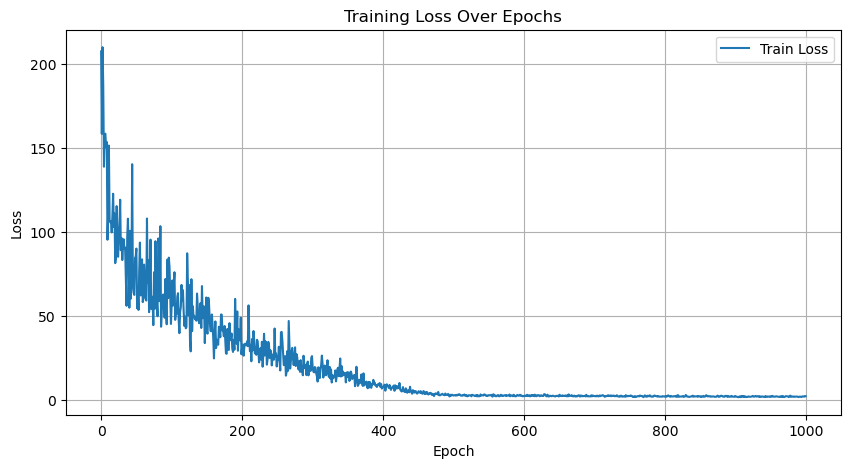

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
avg_loss, f1, precision, recall, all_preds, all_labels, all_ids = test_epoch(
    model, 
    loader_val, 
    criterion, 
    device
)

print(f"Validation Loss: {val_loss:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Validation Loss: 1.1527
F1 Score: 0.6152
Precision: 0.6095
Recall: 0.6234


## Submission

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=_hjorth_transform,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [49]:
def generate_submission_file(model, test_loader, single_graph_edge_index, device, output_filename="submission.csv"):
    """
    Generates a Kaggle submission file for the GAT model.

    Args:
        model (nn.Module): The trained GATClassifier model.
        test_loader (DataLoader): DataLoader for the test set. It must yield
                                  batches of (x_batch, ids_batch).
        single_graph_edge_index (torch.Tensor): The pre-computed edge_index for a single graph.
        device (torch.device): The device to run inference on (e.g., 'cuda' or 'cpu').
        output_filename (str): The name of the output CSV file.
    """
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_ids = []

    # Move the single-graph edge_index to the correct device once
    edge_index_template = single_graph_edge_index.to(device)

    # Disable gradient computation for faster inference
    with torch.no_grad():
        for x_batch, ids_batch in tqdm(test_loader, desc="Generating Submission"):
            # x_batch shape: (batch_size, num_nodes, num_features)
            
            x_batch = x_batch.float().to(device)
            B, N, F = x_batch.shape

            # --- On-the-fly Batch Conversion for GAT model ---
            x_pyg = x_batch.reshape(-1, F)
            batch_vector = torch.arange(B, device=device).repeat_interleave(N)
            edge_indices = [edge_index_template + i * N for i in range(B)]
            batched_edge_index = torch.cat(edge_indices, dim=1)
            # --- Conversion Complete ---

            # Forward pass to get model logits
            # We only need the logits, so we discard the attention weights with `_`
            logits, _ = model(x_pyg, batched_edge_index, batch_vector)

            # Convert logits to binary predictions (0 or 1)
            # A logit > 0 corresponds to a probability > 0.5 after sigmoid
            predictions = (logits > 0).int().cpu().squeeze().tolist()

            # Ensure predictions are in a list, even for a single-item batch
            if not isinstance(predictions, list):
                predictions = [predictions]

            # Store predictions and their corresponding IDs
            all_predictions.extend(predictions)
            all_ids.extend(list(ids_batch))

    # Create a DataFrame for the submission file
    print("Creating submission DataFrame...")
    submission_df = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions
    })

    # Save the DataFrame to a CSV file
    submission_df.to_csv(output_filename, index=False)
    print(f"Submission file saved successfully to: {output_filename}")

In [56]:
# 3. Create the DataLoader for the test set
#    shuffle=False is crucial for submission.
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

# 4. Call the function to generate the file
#    Ensure your model, single_graph_edge_index, and device are defined
generate_submission_file(
    model=model,
    test_loader=loader_te,
    single_graph_edge_index=single_graph_edge_index, # The same one used for training
    device=device,
    output_filename="gat_submission.csv"
)

Generating Submission: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 108.93it/s]

Creating submission DataFrame...
Submission file saved successfully to: gat_submission.csv


In [57]:
# change the gat_submission.csv file lines from p_q_e_j_g_v_e_j___s_0_0_1___t_0_0_0___1_5_7 to pqejgvej_s001_t000_157 format
def format_submission_ids(submission_file):
    """
    Formats the IDs in the submission file to the required format.
    """
    df = pd.read_csv(submission_file)
    
    # Define a function to format each ID
    def format_id(id_str):
        parts = id_str.split("___")
        parts = [part.replace("_", "") for part in parts]
        return "_".join(parts)
    
    # Apply the formatting function to the 'id' column
    df['id'] = df['id'].apply(format_id)
    
    # Save the formatted DataFrame back to CSV
    df.to_csv(submission_file, index=False)
    print(f"Formatted submission file saved successfully to: {submission_file}")

In [58]:
format_submission_ids("gat_submission.csv")

Formatted submission file saved successfully to: gat_submission.csv


## K-Fold evaluation

In [29]:
sys.path.append("/home/stnikoli/nml_project/")
from evaluation import evaluate

In [30]:
for dt in [np.inf]:
    single_graph_edge_index = create_graph_edge_index(
        distances_path=DATA_ROOT / "distances_3d.csv",
        distance_threshold = dt
    )
    # Move the single-graph edge_index to the correct device once
    edge_index_template = single_graph_edge_index.to(device)
    avg_f1_score, std_f1_score = evaluate(
        model=GATClassifier,
        clips=clips_tr,
        signals_root=DATA_ROOT / "train",
        num_epochs=1000,
        learning_rate=1e-4,
        batch_size=512,
        threshold=0.5,
        prefetch=True,
        signal_transform=_hjorth_transform,
        model_args={"num_node_features": 15, "num_classes": 1, "edge_index_template": edge_index_template, "evaluate":True},
        criterion=nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight], device=device)),
        k_folds=5
    )

Fold 1/5


Training Fold 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:13<00:00,  3.19it/s]


Fold 1 F1 Score: 0.5192
Fold 2/5


Training Fold 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:29<00:00,  3.03it/s]


Fold 2 F1 Score: 0.5748
Fold 3/5


Training Fold 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:40<00:00,  2.93it/s]


Fold 3 F1 Score: 0.5494
Fold 4/5


Training Fold 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:15<00:00,  3.17it/s]


Fold 4 F1 Score: 0.4733
Fold 5/5


Training Fold 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:58<00:00,  2.79it/s]

Fold 5 F1 Score: 0.5710
Cross-Validation Average F1 Score: 0.5375
Cross-Validation F1 Score Standard Deviation: 0.0377


## Interpretation

In [17]:
single_graph_edge_index = create_graph_edge_index(
    distances_path=DATA_ROOT / "distances_3d.csv",
    distance_threshold = None
)
# Move the single-graph edge_index to the correct device once
edge_index_template = single_graph_edge_index.to(device)

In [18]:
model = GATClassifier(num_node_features=15, num_classes=1, edge_index_template=edge_index_template) # num_classes=1 for BCEWithLogitsLoss

# Or load a pre-trained model if available
model.load_state_dict(torch.load(BASE_DIR + "/run_half_edges/gat_model_epoch_1000.pth"))
model = model.to(device)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# You may need to adjust this list to match the order in your dataset
ELECTRODE_LABELS = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz'
]

# Define approximate 10-20 system 2D coordinates for the electrodes
# These are relative coordinates; you can adjust the scaling as needed.
# (x, y) coordinates: x is left-right, y is front-back
# (0,0) is roughly Cz
ELECTRODE_POSITIONS = {
    'Fp1': (-0.3, 1.0), 'Fp2': (0.3, 1.0),
    'F3': (-0.4, 0.6), 'F4': (0.4, 0.6),
    'C3': (-0.5, 0.0), 'C4': (0.5, 0.0),
    'P3': (-0.4, -0.6), 'P4': (0.4, -0.6),
    'O1': (-0.2, -1.0), 'O2': (0.2, -1.0),
    'F7': (-0.6, 0.4), 'F8': (0.6, 0.4),
    'T3': (-0.8, 0.0), 'T4': (0.8, 0.0),
    'T5': (-0.6, -0.4), 'T6': (0.6, -0.4),
    'Fz': (0.0, 0.75),
    'Cz': (0.0, 0.0),
    'Pz': (0.0, -0.75)
}

# Ensure all labels in ELECTRODE_LABELS have a corresponding position
# This is a good sanity check
for label in ELECTRODE_LABELS:
    if label not in ELECTRODE_POSITIONS:
        print(f"Warning: Electrode {label} missing from ELECTRODE_POSITIONS. It won't be plotted correctly.")


def get_average_attention(model, loader, device, edge_index_template):
    """
    Runs the model on the dataset and computes the average attention weights
    for seizure and non-seizure classes.
    """
    model.eval()

    seizure_attention_sum = 0
    non_seizure_attention_sum = 0
    seizure_count = 0
    non_seizure_count = 0

    num_nodes = len(ELECTRODE_LABELS)
    num_edges = edge_index_template.shape[1]

    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader, desc="Extracting Attention", leave=False):
            x_batch = x_batch.float().to(device)
            B = x_batch.shape[0]

            # Get model output and attention weights
            _, attention_weights_tuple = model(x_batch)

            # attention_weights_tuple is (edge_index, attention_scores)
            # attention_scores shape: [num_total_edges, num_heads]
            attention_scores = attention_weights_tuple[1]

            # Average across attention heads -> [num_total_edges, 1]
            attention_scores = attention_scores.mean(dim=1)

            # Reshape to match batch structure: (B, num_edges_per_graph)
            attention_per_graph = attention_scores.reshape(B, num_edges)

            for i in range(B):
                label = y_batch[i].item()
                if label == 1:
                    seizure_attention_sum += attention_per_graph[i]
                    seizure_count += 1
                else:
                    non_seizure_attention_sum += attention_per_graph[i]
                    non_seizure_count += 1

    # Calculate averages
    avg_seizure_attention = seizure_attention_sum / seizure_count if seizure_count > 0 else torch.zeros(num_edges)
    avg_non_seizure_attention = non_seizure_attention_sum / non_seizure_count if non_seizure_count > 0 else torch.zeros(num_edges)

    return avg_seizure_attention.cpu().numpy(), avg_non_seizure_attention.cpu().numpy()

In [26]:
from matplotlib.colors import LinearSegmentedColormap
def plot_single_attention_subplot(ax, graph, pos, labels, attention_scores, edge_index, title, percentile_threshold, cmap, norm):
    """Enhanced helper function to plot attention for a single subplot."""
    if np.sum(attention_scores) == 0:
        ax.text(0.5, 0.5, "No data or zero attention.", 
                horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontsize=14, fontweight='medium', color='#2c3e50')
        ax.set_title(title, size=16, weight='bold', color='#2c3e50', pad=15)
        ax.axis('off')
        return

    threshold = np.percentile(attention_scores, percentile_threshold)
    mask = attention_scores >= threshold
    top_edges_index = edge_index[:, mask]
    top_scores = attention_scores[mask]

    # Create a subgraph with only the top edges for drawing
    sub_g = nx.Graph()
    sub_g.add_nodes_from(graph.nodes(data=True))
    sub_g.add_edges_from(top_edges_index.t().cpu().numpy())

    edge_colors = cmap(norm(top_scores))
    # Enhanced edge widths with better scaling
    edge_widths = np.clip(top_scores * 15, 2, 8)  # Min width 2, max width 8

    # Enhanced node styling
    nx.draw_networkx_nodes(sub_g, pos, ax=ax, 
                          node_color='#34495e',  # Dark blue-grey
                          node_size=1500, 
                          alpha=0.9, 
                          linewidths=2.5, 
                          edgecolors='#2c3e50')  # Darker border
    
    # Enhanced edge styling
    nx.draw_networkx_edges(
        sub_g,
        pos,
        ax=ax,
        edgelist=sub_g.edges(),
        edge_color=edge_colors,
        width=edge_widths,
        alpha=0.85,  # Slightly more opaque
        arrows=False
    )
    
    # Enhanced label styling
    nx.draw_networkx_labels(sub_g, pos, ax=ax, labels=labels, 
                           font_size=11, font_weight='bold', 
                           font_color='white', font_family='sans-serif')

    ax.set_title(title, size=16, weight='bold', color='#2c3e50', pad=15)
    ax.axis('off')


def plot_attention_side_by_side(avg_non_seizure_attn, avg_seizure_attn, edge_index, title, output_path=None, percentile_threshold=90.0):
    """
    Enhanced visualization of average attention weights for non-seizure and seizure classes side-by-side.
    
    Args:
        avg_non_seizure_attn (np.array): Array of attention scores for non-seizure class.
        avg_seizure_attn (np.array): Array of attention scores for seizure class.
        edge_index (torch.Tensor): The graph's edge_index.
        title (str): The main title for the entire plot.
        output_path (str, optional): The path to save the plot. If None, the plot is shown.
        percentile_threshold (float): The percentile to use as a threshold for displaying
                                      edges (e.g., 90.0 for top 10%).
    """
    # Set enhanced styling
    plt.style.use('default')  # Reset to default first
    
    # Enhanced font configuration
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Inter', 'Arial', 'Helvetica', 'Liberation Sans', 'DejaVu Sans'],
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18,
        'mathtext.fontset': 'custom',
        'axes.spines.left': False,
        'axes.spines.bottom': False,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': False
    })

    # Create figure with enhanced layout
    fig = plt.figure(figsize=(18, 9))  # Slightly reduced height, maintained width
    
    # Create subplots with custom spacing
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.15, 
                         left=0.05, right=0.85, top=0.85, bottom=0.1)
    
    axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]

    # Define common graph elements
    g = nx.Graph()
    for i, label in enumerate(ELECTRODE_LABELS):
        g.add_node(i, label=label)
    pos = {i: ELECTRODE_POSITIONS[ELECTRODE_LABELS[i]] for i in range(len(ELECTRODE_LABELS))}
    labels = {i: g.nodes[i]['label'] for i in g.nodes()}

    # Enhanced colormap - using a professional scientific palette
    # Create a custom colormap that goes from deep blue to bright orange/red
    colors = ['#0d1b2a', '#1b263b', '#415a77', '#778da9', '#e0e1dd', '#f4a261', '#e76f51', '#d62828']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('custom_attention', colors, N=n_bins)
    
    # Determine global min/max for color normalization
    all_attention_scores = np.concatenate([avg_non_seizure_attn, avg_seizure_attn])
    global_vmin = np.min(all_attention_scores)
    global_vmax = np.max(all_attention_scores)
    
    norm = plt.Normalize(vmin=global_vmin, vmax=global_vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Plot both subplots
    subplot_titles = ["Non-Seizure Attention", "Seizure Attention"]
    attention_data = [avg_non_seizure_attn, avg_seizure_attn]
    
    for i, (ax, attn_data, subplot_title) in enumerate(zip(axes, attention_data, subplot_titles)):
        plot_single_attention_subplot(ax, g, pos, labels, attn_data, edge_index, 
                                      title=subplot_title, percentile_threshold=percentile_threshold,
                                      cmap=cmap, norm=norm)
        ax.set_aspect('equal')
        
        # Remove any remaining whitespace/padding
        ax.margins(0.02)

    # Enhanced colorbar
    cbar_ax = fig.add_axes([0.87, 0.15, 0.025, 0.65])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Average Attention Weight', labelpad=20, fontweight='bold', 
                   fontsize=14, color='#2c3e50')
    cbar.ax.tick_params(labelsize=12, colors='#2c3e50')
    
    # Style the colorbar
    cbar.outline.set_linewidth(0)
    cbar.ax.yaxis.set_tick_params(width=0)

    # # Enhanced main title
    # fig.suptitle(f"{title}\n(Top {100 - percentile_threshold:.0f}% Attention Edges)", 
    #             size=20, weight='bold', color='#2c3e50', y=0.95,
    #             fontfamily='sans-serif')

    # Set background color
    fig.patch.set_facecolor('#fefefe')
    for ax in axes:
        ax.set_facecolor('#fefefe')
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight', 
                   facecolor='#fefefe', edgecolor='none')
        print(f"Enhanced plot saved to {output_path}")
    
    plt.show()
def create_professional_attention_plot(avg_non_seizure_attn, avg_seizure_attn, edge_index, 
                                     title="EEG Attention Analysis", output_path=None, 
                                     percentile_threshold=95.0, style='modern'):
    """
    Creates a publication-ready attention visualization with multiple style options.
    
    Args:
        style (str): 'modern', 'classic', or 'dark' - different visual themes
    """
    
    if style == 'dark':
        # Dark theme configuration
        plt.style.use('dark_background')
        node_color = '#e74c3c'
        text_color = 'white'
        bg_color = '#2c3e50'
        colors = ['#2c3e50', '#34495e', '#3498db', '#e74c3c', '#f39c12', '#f1c40f']
        
    elif style == 'classic':
        # Classic academic style
        node_color = '#2c3e50'
        text_color = '#2c3e50'
        bg_color = 'white'
        colors = ['#f8f9fa', '#e9ecef', '#6c757d', '#495057', '#343a40', '#212529']
        
    else:  # modern (default)
        node_color = '#34495e'
        text_color = '#2c3e50'
        bg_color = '#fefefe'
        colors = ['#0d1b2a', '#1b263b', '#415a77', '#778da9', '#e0e1dd', '#f4a261', '#e76f51', '#d62828']
    
    # Apply the chosen style
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
    
    # Use the main plotting function with style-specific parameters
    plot_attention_side_by_side(avg_non_seizure_attn, avg_seizure_attn, edge_index, 
                               title, output_path, percentile_threshold)

Enhanced plot saved to /home/stnikoli/nml_project/GAT/images/professional_attention_plot.svg


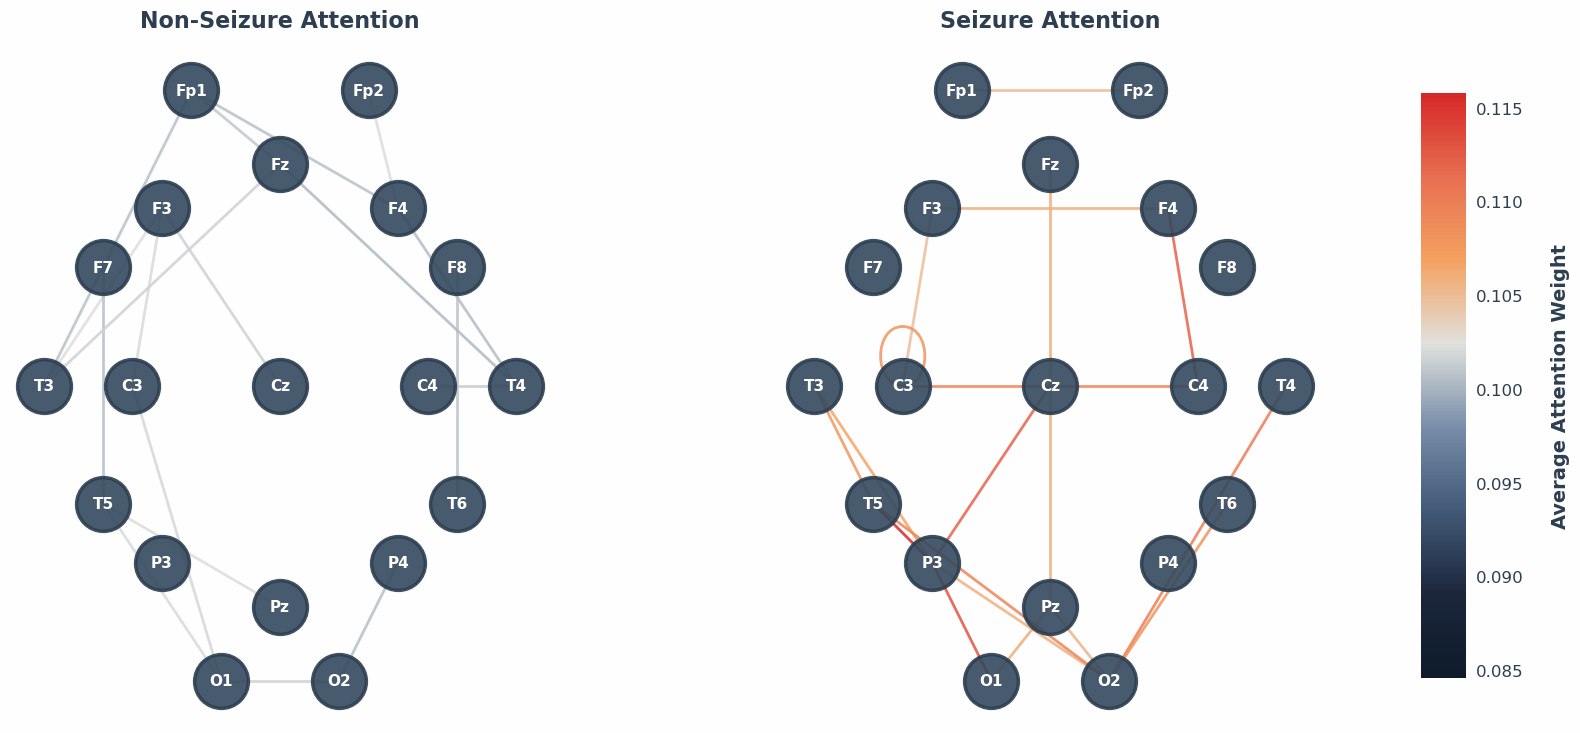

In [28]:
create_professional_attention_plot(
    avg_non_seizure_attn, 
    avg_seizure_attn, 
    single_graph_edge_index, 
    title="",
    output_path=BASE_DIR + "/images/professional_attention_plot.svg",
    percentile_threshold=90,
    style='modern'  # or 'classic' or 'dark'
)